In [41]:

pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
# imports
import torch
from torch import nn
import datasets as ds
from pprint import pprint
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchtext.vocab import build_vocab_from_iterator

In [43]:
# prepering data

# A - load and process the dataset
dataset = ds.load_dataset("glue", "sst2")
sentence_list = dataset["train"]["sentence"]
labels_list   = dataset["train"]["label"]
tokenize      = lambda x: x.split()
tokenized     = list(map(tokenize, sentence_list))

# create vocabulary
vocab = build_vocab_from_iterator(tokenized, specials=[""], min_freq=5)
vocab.set_default_index(0)

# convert string to int
func = lambda x: torch.tensor(vocab(x))
integer_tokens = list(map(func, tokenized))
label_tensors  = list(map(torch.tensor, labels_list))

# split to train and test
test_split   = len(integer_tokens) * 8//10
train_tokens = integer_tokens[:test_split]
train_labels = label_tensors[:test_split]
test_tokens  = integer_tokens[test_split:]
test_labels  = label_tensors[test_split:]

  0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
# B RNN for data classification
class FasterDeepRNNClassifier(nn.Module):
  def __init__(self, embed_dim, hidden_dim, RNNlayers):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(len(vocab),embed_dim)
    self.rnn_stack = nn.RNN(embed_dim, hidden_dim,RNNlayers)
    self.linear = nn.Linear(hidden_dim, 2)
    self.logsoftmax = nn.LogSoftmax(dim=0)
  def forward(self, sentence_tokens):
    all_embeddings = self.embedding(sentence_tokens)
    all_embeddings = all_embeddings.unsqueeze(1)
    hidden_state_history, _= self.rnn_stack(all_embeddings)
    feature_extractor_output = hidden_state_history[-1,0,:]
    class_scores = self.linear(feature_extractor_output)
    logprobs = self.logsoftmax(class_scores)
    return logprobs

def iterate_one_sentence(tokens, label, train_flag):
  if train_flag:
    model.train()  
    optimizer.zero_grad()
    y_model = model(tokens)
    loss    = -y_model[label] #Cross Entropy
    loss.backward()
    optimizer.step()
  else:
    model.eval()
    y_model = model(tokens)
    model.train()
  with torch.no_grad():
    predicted_labels = y_model.argmax()
    success = (predicted_labels == label)
  return success

In [45]:
# Q1

model = FasterDeepRNNClassifier(50, 5, 5)
optimizer = torch.optim.AdamW(model.parameters())

# overfit a small batch to check if learning _can_ occur
num_samples, epochs = 200, 20
parameters = list(model.parameters())
avg_grad_norms = torch.zeros(epochs)

# train
for epoch in range(epochs):
    correct_predictions = torch.tensor([0.])
    grad_norm_temp = torch.zeros(num_samples)
    sentence_gradients = []  # Mean gradients for each token in the sentence
    for idx in tqdm(range(num_samples)):
        correct_predictions += iterate_one_sentence(train_tokens[idx], train_labels[idx], train_flag=True)
        norms = [p.grad.detach().abs().max() for p in parameters if p.grad is not None]
        grad_norm_temp[idx] = torch.max(torch.stack(norms))

        # Calculate mean gradients for each token in the input sentence
        token_gradients = [p.grad.detach().abs().mean() for p in parameters if p.grad is not None]
        if len(sentence_gradients) == 0:
            sentence_gradients = token_gradients
        else:
            sentence_gradients = [sg + tg for sg, tg in zip(sentence_gradients, token_gradients)]

    avg_grad_norms[epoch] = grad_norm_temp.mean()
    acc = correct_predictions / num_samples
    if epoch % 10 == 0:
        print("Epoch", epoch, " acc:", acc.item())
        # Print the mean gradients for each token in the sentence
        print("Mean gradients for each token:")
        for token_index, gradient in enumerate(sentence_gradients):
            print("Token", token_index, ":", gradient.item())

# test
test_correct_predictions = torch.tensor([0.])
for tokens, label in tqdm(zip(test_tokens, test_labels), total=len(test_tokens)):
    test_correct_predictions += iterate_one_sentence(tokens, label, train_flag=False)
test_acc = test_correct_predictions / len(test_tokens)

print(acc, test_acc, sep="\n")



100%|██████████| 200/200 [00:07<00:00, 25.40it/s]


Epoch 0  acc: 0.5099999904632568
Mean gradients for each token:
Token 0 : 5.6553461035946384e-05
Token 1 : 0.5155762434005737
Token 2 : 0.43635761737823486
Token 3 : 0.4438784718513489
Token 4 : 0.4438784718513489
Token 5 : 1.699069619178772
Token 6 : 0.8770310878753662
Token 7 : 1.7023639678955078
Token 8 : 1.7023640871047974
Token 9 : 3.8833067417144775
Token 10 : 3.320596218109131
Token 11 : 8.265433311462402
Token 12 : 8.265433311462402
Token 13 : 3.1245369911193848
Token 14 : 4.338393688201904
Token 15 : 6.782926559448242
Token 16 : 6.782926559448242
Token 17 : 20.7335205078125
Token 18 : 11.856162071228027
Token 19 : 30.08437156677246
Token 20 : 30.08437156677246
Token 21 : 40.678672790527344
Token 22 : 100.94650268554688


100%|██████████| 200/200 [00:04<00:00, 43.89it/s]


Epoch 10  acc: 1.0
Mean gradients for each token:
Token 0 : 8.538070687791333e-05
Token 1 : 0.6961354613304138
Token 2 : 0.6247379779815674
Token 3 : 0.7077778577804565
Token 4 : 0.7077778577804565
Token 5 : 2.0343711376190186
Token 6 : 1.1148555278778076
Token 7 : 1.3929978609085083
Token 8 : 1.3929978609085083
Token 9 : 0.7088034749031067
Token 10 : 0.6558895111083984
Token 11 : 0.8252984881401062
Token 12 : 0.8252984881401062
Token 13 : 0.4276160001754761
Token 14 : 0.5860615372657776
Token 15 : 0.6314535140991211
Token 16 : 0.6314535140991211
Token 17 : 0.8505582213401794
Token 18 : 0.779582679271698
Token 19 : 1.0703870058059692
Token 20 : 1.0703870058059692
Token 21 : 2.625898599624634
Token 22 : 3.8199527263641357


100%|██████████| 13470/13470 [00:31<00:00, 429.11it/s]

tensor([1.])
tensor([0.5056])


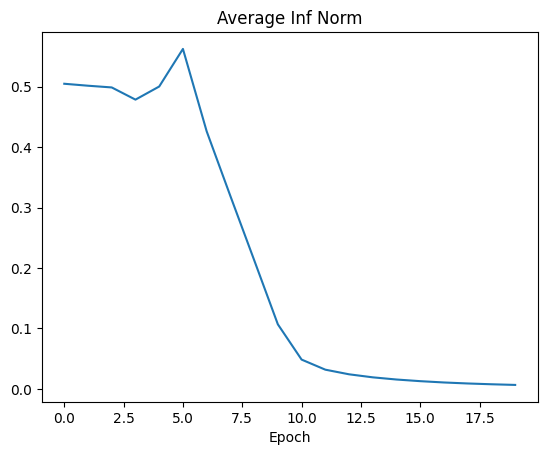

In [46]:
plt.plot(avg_grad_norms)
plt.xlabel("Epoch")
plt.title("Average Inf Norm");

In [47]:
# Q2
class BasicRNNCell(nn.Module):
  def __init__(self,embed_dim,hidden_dim):
    super().__init__()
    self.hidden_state = torch.zeros(hidden_dim)
    self.hidden_linear = nn.Linear(in_features = hidden_dim,
                                   out_features = hidden_dim)
    self.input_linear = nn.Linear(in_features = embed_dim,
                                   out_features = hidden_dim)
    self.activation = nn.Tanh()

  def forward(self, one_embedded_token):
      # A - define H_hat_t
      Z1        = self.input_linear(one_embedded_token)
      Z2        = self.hidden_linear(self.hidden_state)
      Y         = Z1+Z2
      new_state = self.activation(Y) # H_hat_t
      self.hidden_state = new_state

class ModifiedRNNCell(nn.Module):
    def __init__(self,embed_dim,hidden_dim):
      super().__init__()
      self.hidden_state = torch.zeros(hidden_dim)
      self.hidden_state_reset = torch.zeros(hidden_dim)

      self.hidden_linear = nn.Linear(in_features = hidden_dim,
                                   out_features = hidden_dim)
      self.input_linear = nn.Linear(in_features = embed_dim,
                                   out_features = hidden_dim)
      self.reset_linear = nn.Linear(in_features = embed_dim,
                                   out_features = hidden_dim)

      self.tanh_activation = nn.Tanh()

    def forward(self, one_embedded_token):
      input = self.input_linear(one_embedded_token) # X_t - current input
      hidden_state = self.hidden_linear(self.hidden_state) # H_(t-1) - precious hidden state
      H_hat = self.tanh_activation(input + hidden_state)

      # B = define R_t "reset button"
      R_t = self.reset_linear(one_embedded_token) # Depend on input at timestep t only
      # C + D - calculate H_t as H_t_hat * R_t with option to forget the hidden state base on the network learning
      new_H_t = H_hat * R_t
      # E - chose tanh as activation function. when h_t is small, the output of tanh will change it to almost zero, help to forget
      self.hidden_state = self.tanh_activation(new_H_t) # H_t = new hidden state. Sigmoid because output is between 0 to 1 


In [48]:
class BaseRNNClassifier(nn.Module):
  def __init__(self, embed_dim,hidden_dim, is_basic_rnn : True):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(len(vocab),embed_dim)

    if is_basic_rnn:
      self.rnn = BasicRNNCell(embed_dim,hidden_dim)
    else:
      self.rnn = ModifiedRNNCell(embed_dim,hidden_dim)
    self.linear = nn.Linear(hidden_dim, 2)
    self.logsoftmax = nn.LogSoftmax(dim=0)

  def forward(self, sentence_tokens):
    self.rnn.hidden_state = torch.zeros(self.hidden_dim)
    for one_token in sentence_tokens:
      one_embedded_token = self.embedding(one_token)
      self.rnn(one_embedded_token)
    
    feature_extractor_output = self.rnn.hidden_state

    class_scores= self.linear(feature_extractor_output)
    logprobs = self.logsoftmax(class_scores)
    return logprobs

In [49]:
# F train the neural network

## Train without R_t

model = BaseRNNClassifier(10,10,True)
optimizer = torch.optim.AdamW(model.parameters())

# overfit a small batch to check if learning _can_ occur
num_samples, epochs = 200, 20
parameters = list(model.parameters())
avg_grad_norms = torch.zeros(epochs)

# train
for epoch in range(epochs):
  correct_predictions = torch.tensor([0.])
  grad_norm_temp      = torch.zeros(num_samples)
  for idx in tqdm(range(num_samples)):
    correct_predictions += iterate_one_sentence(train_tokens[idx],
                                                train_labels[idx],
                                                train_flag=True)
    norms = [p.grad.detach().abs().max() for p in parameters if p.grad is not None]
    grad_norm_temp[idx] = torch.max(torch.stack(norms))

  avg_grad_norms[epoch] = grad_norm_temp.mean()   
  acc = correct_predictions/num_samples
  if epoch % 3 == 0:
    print("Epoch",epoch," acc:",acc.item())

# test without R_t
test_correct_predictions = torch.tensor([0.])
for tokens, label in tqdm(zip(test_tokens, test_labels), total=len(test_tokens)):
  test_correct_predictions += iterate_one_sentence(tokens, label, train_flag=False)
test_acc = test_correct_predictions / len(test_tokens)

print(acc, test_acc, sep="\n")

100%|██████████| 200/200 [00:01<00:00, 141.71it/s]


Epoch 0  acc: 0.49000000953674316


100%|██████████| 200/200 [00:01<00:00, 103.59it/s]


Epoch 3  acc: 0.6100000143051147


100%|██████████| 200/200 [00:02<00:00, 93.05it/s]


Epoch 6  acc: 0.6899999976158142


100%|██████████| 200/200 [00:01<00:00, 141.95it/s]


Epoch 9  acc: 0.7699999809265137


100%|██████████| 200/200 [00:01<00:00, 130.14it/s]


Epoch 12  acc: 0.8849999904632568


100%|██████████| 200/200 [00:01<00:00, 137.44it/s]


Epoch 15  acc: 0.9449999928474426


100%|██████████| 200/200 [00:01<00:00, 136.21it/s]


Epoch 18  acc: 0.9900000095367432


100%|██████████| 13470/13470 [00:21<00:00, 621.18it/s]

tensor([0.9900])
tensor([0.4987])


100%|██████████| 200/200 [00:01<00:00, 119.69it/s]


Epoch 0  acc: 0.49000000953674316


100%|██████████| 200/200 [00:01<00:00, 114.01it/s]


Epoch 3  acc: 0.6700000166893005


100%|██████████| 200/200 [00:01<00:00, 104.86it/s]


Epoch 6  acc: 0.8600000143051147


100%|██████████| 200/200 [00:02<00:00, 88.86it/s]


Epoch 9  acc: 0.9449999928474426


100%|██████████| 200/200 [00:01<00:00, 108.11it/s]


Epoch 12  acc: 0.9800000190734863


100%|██████████| 200/200 [00:02<00:00, 71.34it/s]


Epoch 15  acc: 1.0


100%|██████████| 200/200 [00:01<00:00, 116.65it/s]


Epoch 18  acc: 1.0


100%|██████████| 13470/13470 [00:31<00:00, 424.33it/s]

tensor([1.])
tensor([0.5034])


Text(0.5, 1.0, 'Average Inf Norm')

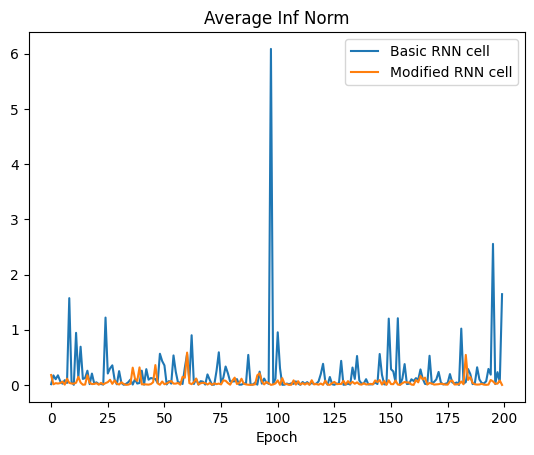

In [50]:
## train with R_t

model = BaseRNNClassifier(10,10,False)
optimizer = torch.optim.AdamW(model.parameters())

# overfit a small batch to check if learning _can_ occur
num_samples, epochs = 200, 20
parameters = list(model.parameters())
avg_grad_norms = torch.zeros(epochs)

# train
for epoch in range(epochs):
  correct_predictions = torch.tensor([0.])
  modified_grad_norm_temp      = torch.zeros(num_samples)
  for idx in tqdm(range(num_samples)):
    correct_predictions += iterate_one_sentence(train_tokens[idx],
                                                train_labels[idx],
                                                train_flag=True)
    norms = [p.grad.detach().abs().max() for p in parameters if p.grad is not None]
    modified_grad_norm_temp[idx] = torch.max(torch.stack(norms))

  avg_grad_norms[epoch] = modified_grad_norm_temp.mean()   
  acc = correct_predictions/num_samples
  if epoch % 3 == 0:
    print("Epoch",epoch," acc:",acc.item())

# test with R_t
test_correct_predictions = torch.tensor([0.])
for tokens, label in tqdm(zip(test_tokens, test_labels), total=len(test_tokens)):
  test_correct_predictions += iterate_one_sentence(tokens, label, train_flag=False)
test_acc = test_correct_predictions / len(test_tokens)

print(acc, test_acc, sep="\n")

plt.plot(grad_norm_temp,label = "Basic RNN cell")
plt.plot(modified_grad_norm_temp, label = "Modified RNN cell")
plt.legend()
plt.xlabel("Epoch")
plt.title("Average Inf Norm")
